In [1]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from sklearn.utils import class_weight , compute_class_weight


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam , SGD, RMSprop
from keras.utils import array_to_img, img_to_array, load_img
from keras.regularizers import l1 , l2 
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine

# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (200, 200),
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size=16, class_mode='binary')


In [ ]:
# may try data augmentation if needed 

# Data Augmentation will be performed only on the training set
# All image sets will be rescaled by 1./255
#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   rotation_range=20, 
#                                   width_shift_range=0.2, 
#                                   height_shift_range=0.2, 
#                                   shear_range=0.2, 
#                                   zoom_range=0.2, 
#                                   horizontal_flip=True)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [5]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

print("Label Dataset Shape")
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)



Image Dataset Shape
(5216, 256, 256, 3)
(624, 256, 256, 3)
(16, 256, 256, 3)
Label Dataset Shape
(5216,)
(624,)
(16,)


In [6]:
example_img = train_images[10]

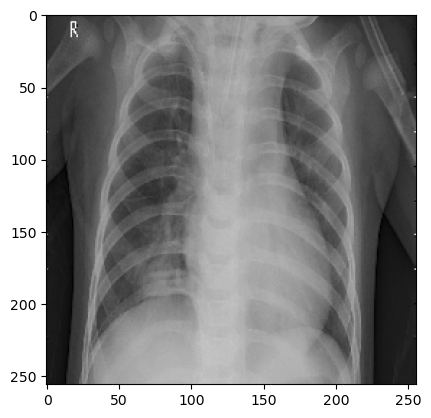

In [7]:
plt.imshow(example_img)

In [8]:
# Reshaping image datasets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [9]:
train_img[:10]

array([[0.0627451 , 0.0627451 , 0.0627451 , ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.03921569, 0.03921569, 0.03921569, ..., 0.01176471, 0.01176471,
        0.01176471],
       [0.        , 0.        , 0.        , ..., 0.04313726, 0.04313726,
        0.04313726],
       ...,
       [0.22352943, 0.22352943, 0.22352943, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28627452, 0.28627452, 0.28627452, ..., 0.08235294, 0.08235294,
        0.08235294]], dtype=float32)

In [10]:
# Reshaping labels
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 1)
(624, 1)
(16, 1)


In [11]:
# Viewing first 10 labels
train_y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [12]:
# Viewing class indices
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Baseline CNN Model 

In [ ]:
# cnn baseline model

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters= 32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Inspecting model summary
cnn_model.summary()

# Fit and train the model 
cnn_model.fit(train_images, train_labels, epochs=10, batch_size=128)


In [20]:
# cnn baseline model

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters= 32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [21]:
# Inspecting model summary

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [22]:
# Adding dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [23]:
# Inspecting model summary

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 230400)           

In [24]:
# Compiling model with following parameters
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [25]:
# Fit and train the model 
cnn_model.fit(train_images, train_labels, epochs=10, batch_size= 128)

Epoch 1/10
 3/41 [=>............................] - ETA: 15:41 - loss: 4.2185 - accuracy: 0.7344

KeyboardInterrupt: 

## Baseline Model 

In [12]:
# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                2359308   
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the model to the training data
results_1 = model_1.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Epoch 1/10
163/163 [==============================] - 30s 169ms/step - loss: 0.6825 - accuracy: 0.7398 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 22s 136ms/step - loss: 0.6093 - accuracy: 0.7429 - val_loss: 0.7431 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 14s 86ms/step - loss: 0.5788 - accuracy: 0.7429 - val_loss: 0.7895 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 17s 102ms/step - loss: 0.5714 - accuracy: 0.7429 - val_loss: 0.8126 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 13s 79ms/step - loss: 0.5702 - accuracy: 0.7429 - val_loss: 0.8231 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 15s 94ms/step - loss: 0.5701 - accuracy: 0.7429 - val_loss: 0.8256 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 11s 66ms/step - loss: 0.5700 - accuracy: 0.7429 - val_loss: 0.8270 - val_accura

In [14]:
# Training Results 
results_train = model_1.evaluate(train_img, train_y)

# Test Results 

results_test = model_1.evaluate(test_img, test_y)

20/20 [==============================] - 3s 108ms/step - loss: 0.6930 - accuracy: 0.6250


In [15]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.5700258016586304, 0.7429064512252808]
Test Results: [0.6930213570594788, 0.625]


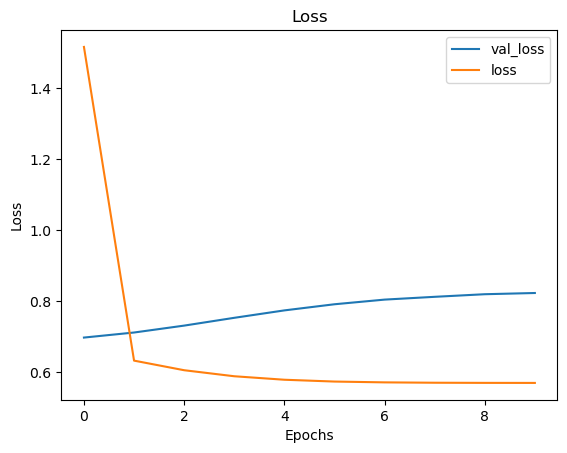

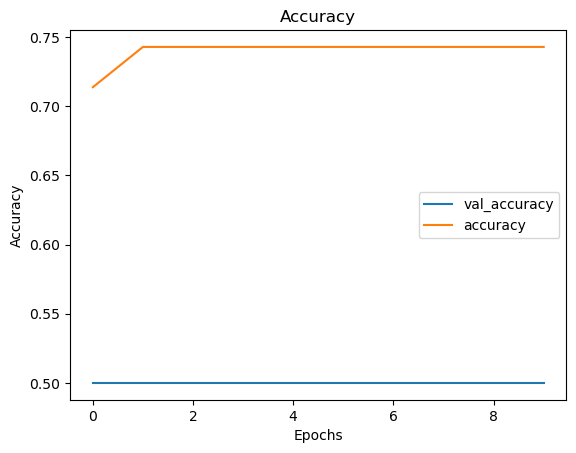

In [16]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_1)

## Model 2